In [1]:
from IPython.core.display import HTML, display
import pickle
from warnings import filterwarnings

import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from seaborn import heatmap
import matplotlib.pyplot as pl
from matplotlib import rcParams
from cmocean import cm as cmo

from pymc_utils import PyMCModel
from pymc_utils import subset_significant_feature

In [2]:
filterwarnings('ignore', category=UserWarning)

In [3]:
display(HTML("<style>.container {width: 90% !important}</style>"))

In [4]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [37]:
def bayes_nn_model_l1_h(X, y_obs, n_hidden=None, lklhd_name='likelihood',
                       parameterize_elu=False):
    """
    Hierarchical Bayesian NN Implementation with ARD.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    
    with pm.Model() as model:
        """
        if parameterize_elu:
            alpha_elu = pm.HalfCauchy('alpha_elu', beta=2.5)
        else:
            alpha_elu = 1
        elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden))
        elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden + 1))
        """
        
        beta_hyp_wi1_sd = pm.HalfCauchy('beta_hyp_wi1_sd', beta=2.5)
        hyp_wi1_sd  = pm.HalfCauchy('hyp_w_i_1_sd', beta=beta_hyp_wi1_sd, shape=(num_feats,1))
        hyp_w1o_sd = pm.HalfCauchy('hyp_w_1_out_sd', beta=2.5)
        hyp_bias_1_sd = pm.HalfCauchy('hyp_bias_1', beta=2.5) #revert
        hyp_bias_o_sd = pm.HalfCauchy('hyp_bias_o', beta=2.5)
        
        w_i_1 = pm.Normal('wts_i_1', mu=0, sd=hyp_wi1_sd, shape=(num_feats, n_hidden))
        w_1_o = pm.Normal('wts_1_out', mu=0, sd=hyp_w1o_sd, shape=(n_hidden, ))
        b_1 = pm.Normal('bias_1', mu=0, sd=hyp_bias_1_sd)
        b_o = pm.Normal('bias_o', sd=hyp_bias_o_sd)
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w_i_1),# alpha=alpha_elu
                                                              ) + b_1)
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b_o)
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [6]:
def bayes_nn_model_l1_uncentered(X, y_obs, n_hidden=None, lklhd_name='likelihood',
                       parameterize_elu=False):
    """
    Hierarchical Bayesian NN Implementation with ARD.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    
    with pm.Model() as model:
        
        """
        if parameterize_elu:
            alpha_elu = pm.HalfCauchy('alpha_elu', beta=2.5)
        else:
            alpha_elu = 1
        elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden))
        elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden + 1))
        """
        
        beta_hyp_wi1_sd = pm.HalfCauchy('beta_hyp_wi1_sd', beta=2.5)
        hyp_wi1_sd = pm.HalfCauchy('hyp_w_i_1_sd', beta=beta_hyp_wi1_sd,) #shape=(num_feats,1))
        #hyp_wi1_mu = pm.Normal('hyp_w_i_1_mu', mu=0, sd=5, shape=(num_feats, 1))
        hyp_w1o_sd = pm.HalfCauchy('hyp_w_1_out_sd', beta=2.5)
        #hyp_w1o_mu = pm.Normal('hyp_w1_out_mu', mu=0, sd=5)
        hyp_bias_1_sd = pm.HalfCauchy('hyp_bias_1_sd', beta=2.5) #revert
        #hyp_bias_1_mu = pm.Normal('hyp_bias_1_mu', mu=0, sd=5)
        #hyp_bias_o_mu = pm.Normal('hyp_bias_o_mu', mu=0, sd=5)
        hyp_bias_o_sd = pm.HalfCauchy('hyp_bias_o_sd', beta=2.5)
         
        w_i_1_intrmd = pm.Normal('wts_i_1_intrmd', mu=0, sd=1, shape=(num_feats, n_hidden))
        w_1_o_intrmd = pm.Normal('wts_1_o_intrmd', mu=0, sd=1, shape=(n_hidden,))
        b1_intrmd = pm.Normal('bias_1_intrmd', mu=0, sd=1, shape=(n_hidden,)) # revert
        bo_intrmd = pm.Normal('bias_o_intrmd', mu=0, sd=1, shape=(1,))
        
        w_i_1 = pm.Deterministic('wts_i_1', w_i_1_intrmd * hyp_wi1_sd)
        w_1_o = pm.Deterministic('wts_1_out', w_1_o_intrmd * hyp_w1o_sd)
        #w_i_1 = pm.Normal('wts_i_1', mu=hyp_wi1_mu, sd=hyp_wi1_sd, shape=(num_feats, n_hidden))
        #w_1_o = pm.Normal('wts_1_out', mu=hyp_w1o_mu, sd=hyp_w1o_sd, shape=(n_hidden,))
        b_1 = pm.Deterministic('bias_1', b1_intrmd * hyp_bias_1_sd)
        b_o = pm.Deterministic('bias_o', bo_intrmd * hyp_bias_o_sd)
        #b_1 = pm.Normal('bias_1', mu=hyp_bias_1_mu, sd=hyp_bias_1_sd)
        #b_o = pm.Normal('bias_o', mu=hyp_bias_o_mu, sd=hyp_bias_o_sd)
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w_i_1), #alpha=alpha_elu
                                                              ) + b_1)
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b_o)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [7]:
def plot_pairwise_corr(df_, ax=None, **heatmap_kwgs):
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 10))
    heatmap(df_.corr().iloc[1:,:-1],vmin=-1, vmax=1,
            mask=np.triu(np.ones([df_.shape[1]-1] * 2),k=1),
            ax=ax, **heatmap_kwgs,
            #annot=True, annot_kws={'fontsize': 10}, cmap=cmo.balance_r
           )
    ax.set_facecolor('k')
    return ax

In [8]:
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')
#ds['log10_aphy%d' % band] = np.log10(ds.loc[:, 'aphy%d' % band])
#ds.to_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')

In [9]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy_s,162.0,-7.538551e-17,1.003101,-1.632361,-1.075398,0.291772,0.919767,1.067988
cos_doy_s,162.0,3.807825e-17,1.003101,-1.729100,-0.778317,0.208898,0.685304,1.430161
sin_minofday_s,162.0,1.915477e-16,1.003101,-0.599067,-0.553291,-0.397313,0.053463,4.165531
cos_minofday_s,162.0,-2.193033e-17,1.003101,-1.835295,-0.763772,0.101973,0.788677,2.063419
x_s,162.0,-1.045117e-16,1.003101,-2.523305,0.067800,0.101626,0.322978,2.480050
y_s,162.0,-6.030841e-17,1.003101,-0.570194,-0.540412,-0.281825,-0.081228,4.415726
z_s,162.0,-1.096945e-16,1.003101,-4.151014,0.121210,0.153920,0.480512,1.370943
log10_etopo2_s,162.0,-1.398059e-16,1.003101,-1.962412,-0.768789,-0.369002,0.760279,1.745110
oisst_s,162.0,2.193033e-17,1.003101,-2.990826,-0.781122,0.070849,0.976256,1.396973
solz_s,162.0,-1.072530e-16,1.003101,-1.851402,-0.753258,0.127265,0.760037,1.757741


In [10]:
aphys = ds.filter(regex='^aphy').columns.tolist()
ds.drop(aphys, axis=1, inplace=True)

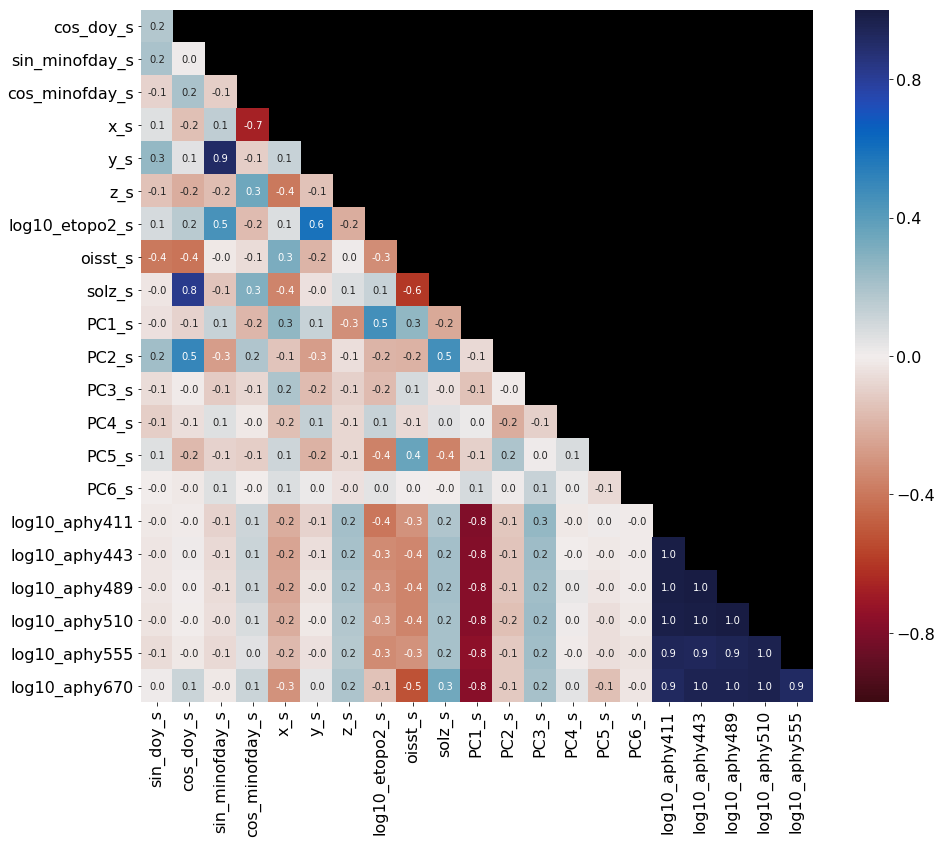

In [11]:
f, ax = pl.subplots(figsize=(14, 12))
plot_pairwise_corr(ds, ax=ax, annot=True, annot_kws=dict(fontsize=10), cmap=cmo.balance_r, fmt='.1f');
f.tight_layout()
f.savefig('/accounts/ekarakoy/WRITEUPS/TOA_ML_Writeup/FigJar/feature_heatmap_annotated.png', dpi=300)

In [12]:
feat_beg = 'x_s'
feat_end_ni = 'PC6_s'

X_s = ds.dropna().loc[:, feat_beg: feat_end_ni]
lbls_X_s = X_s.columns.tolist()
y = ds.dropna().filter(regex='log10_aphy')

In [13]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)
Xy_train = pd.concat((X_s_train, y_train), axis=1)

### Fitting w/ All Features

####  <u>Model 2: Single Layer BNN -- 8-unit HL</u>

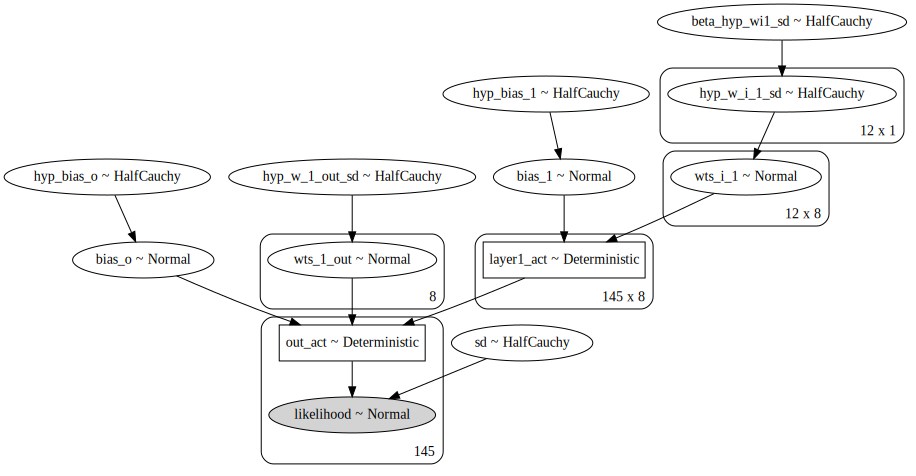

In [38]:
X_shared = shared(X_s_train.values)
bnn_l1_8HL_411 = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train.log10_aphy411, n_hidden=8)
bnn_l1_8HL_411.show_model()

In [44]:
bnn_l1_8HL_411.fit_ADVI(n_iter=25000, inference='svgd', inf_kwargs=dict(n_particles=200))

100%|██████████| 25000/25000 [11:50<00:00, 35.17it/s]


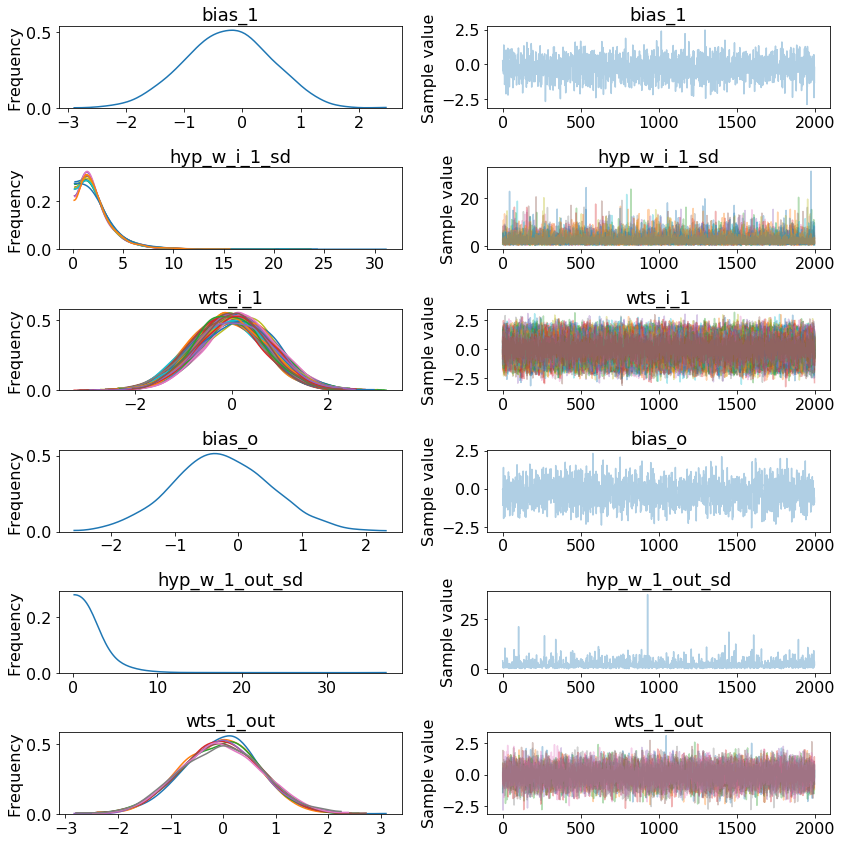

In [42]:
bnn_l1_8HL_411.evaluate_fit(['bias_1', 'hyp_w_i_1_sd','wts_i_1', 'bias_o', 'hyp_w_1_out_sd', 'wts_1_out']);

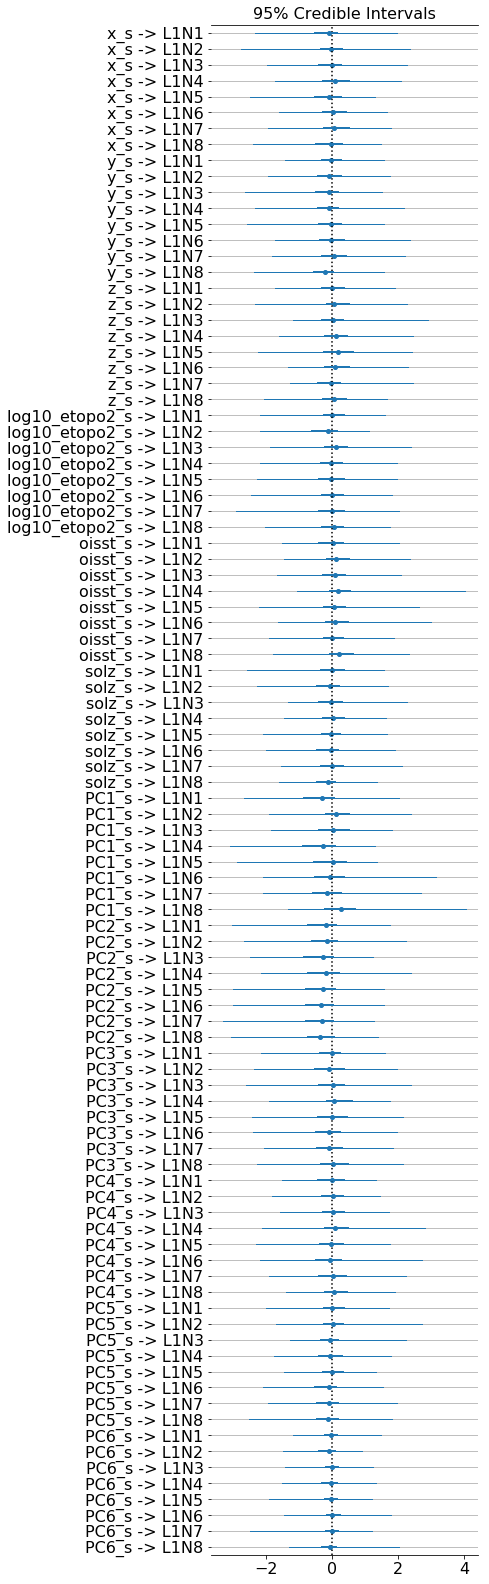

In [30]:
labels = ['%s -> L1N%d' %(li, ni) for li in lbls_X_s for ni in range(1, 9)]
bnn_l1_8HL_411.show_forest(['wts_i_1'], feat_labels=labels)
f = pl.gcf()
f.set_figheight(25);

100%|██████████| 2000/2000 [00:01<00:00, 1343.51it/s]


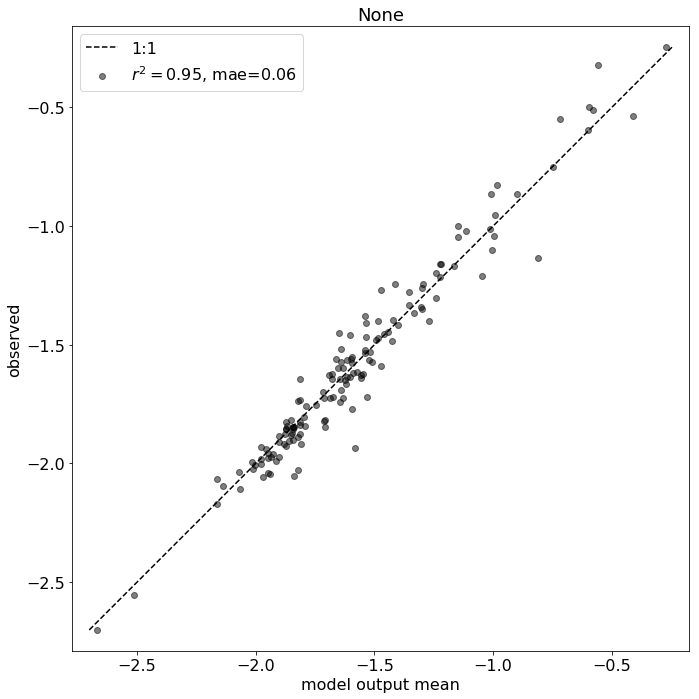

In [45]:
# Check fit on training model
ppc_train_l1_8HL_411 = bnn_l1_8HL_411.predict(likelihood_name='likelihood')
bnn_l1_8HL_411.plot_model_fits(y_train.log10_aphy411, ppc_train_l1_8HL_411, loss_metric='mae', );

100%|██████████| 2000/2000 [00:01<00:00, 1026.83it/s]


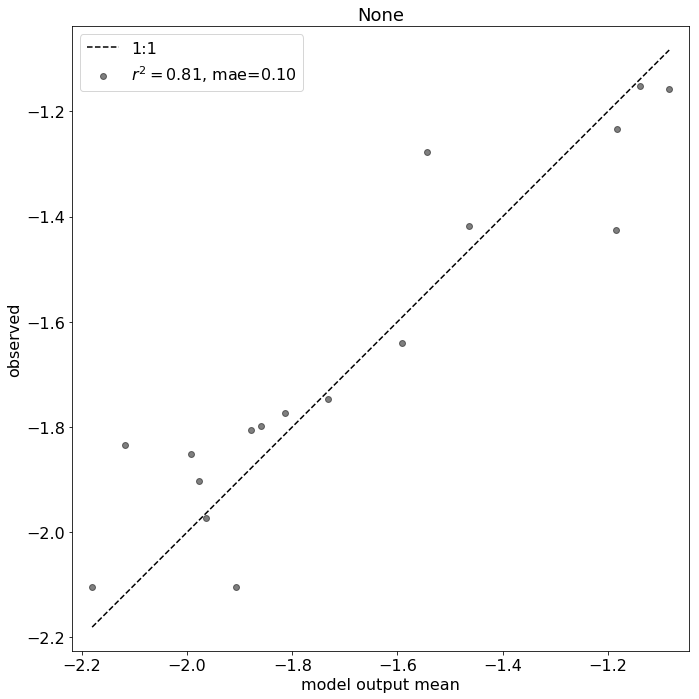

In [46]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l1_8HL_411 = bnn_l1_8HL_411.predict(likelihood_name='likelihood')
bnn_l1_8HL_411.plot_model_fits(y_test.log10_aphy411, ppc_test_l1_8HL_411, loss_metric='mae',);

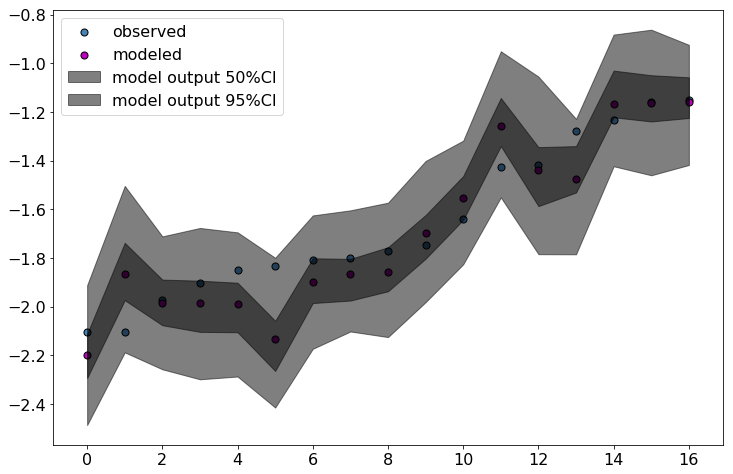

In [45]:
# Plot Fits with Uncertainty Estimates
iy  = np.argsort(y_test.log10_aphy411)
ix = np.arange(iy.size)
ppc_test = ppc_test_l1_8HL_411
lik_mean =ppc_test.mean(axis=0)
lik_hpd = pm.hpd(ppc_test)
lik_hpd_05 = pm.hpd(ppc_test, alpha=0.5)

f_fit2, ax = pl.subplots(figsize=(12, 8))
ax.scatter(ix, y_test.log10_aphy411.values[iy], label='observed', edgecolor='k', s=50,
           color='steelblue');
ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
               label='model output 50%CI');
ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
               label='model output 95%CI');
ax.legend(loc='upper left');
#f_fit2.savefig('./figJar/bayesNet/bNN_L1_nobias.png', dpi=300, format='png')

####  <u>Model 3: Single Layer BNN -- 16-unit HL</u>

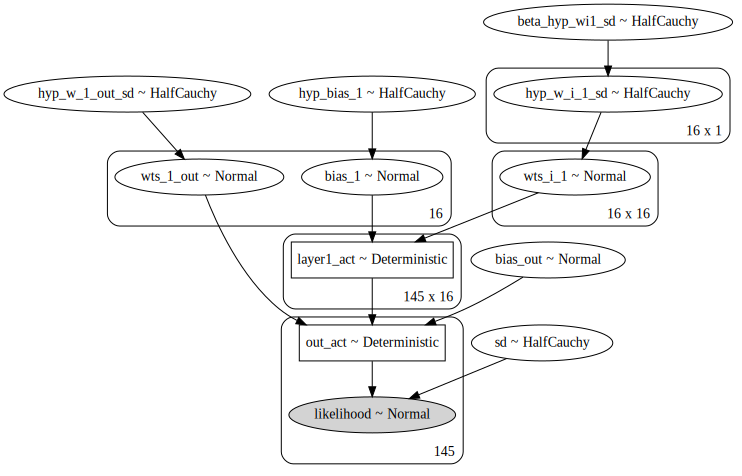

In [74]:
X_shared = shared(X_s_train.values)
bnn_l1_16HL = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train, n_hidden=16, include_bias=True)
bnn_l1_16HL.show_model()

In [75]:
bnn_l1_16HL.fit_ADVI(inference='svgd')

100%|██████████| 100000/100000 [18:49<00:00, 88.53it/s]


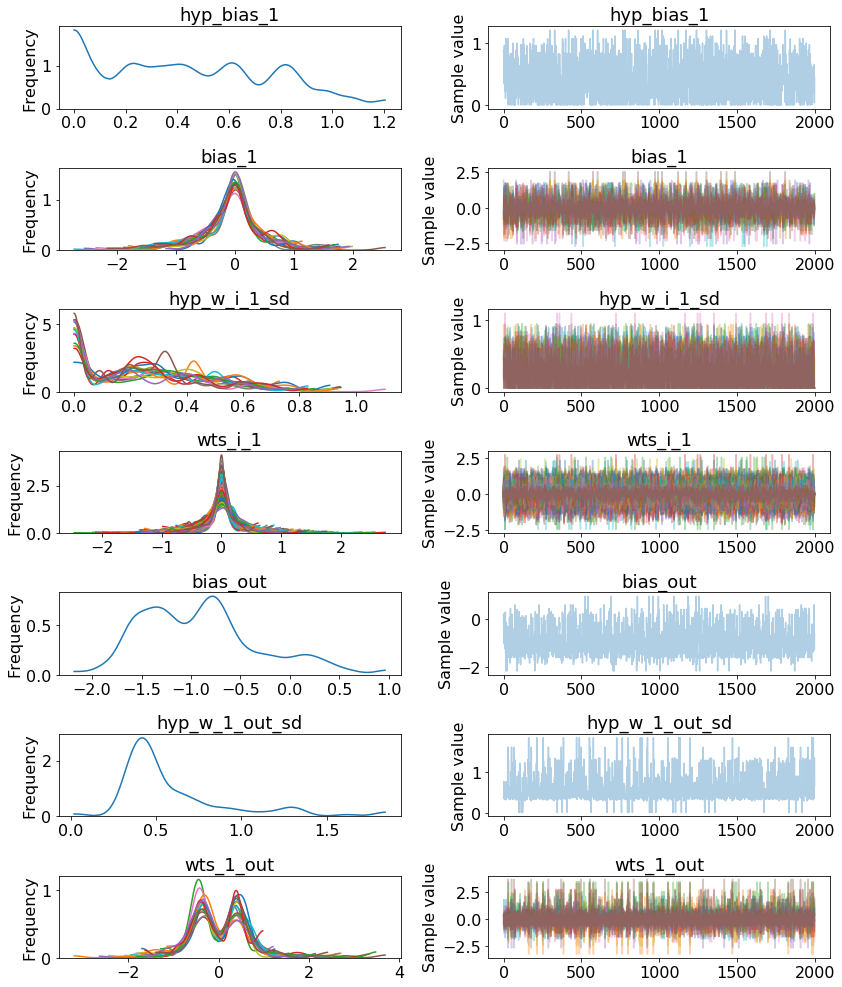

In [80]:
bnn_l1_16HL.evaluate_fit(['hyp_bias_1', 'bias_1', 'hyp_w_i_1_sd','wts_i_1', 'bias_out', 'hyp_w_1_out_sd', 'wts_1_out']);

100%|██████████| 2000/2000 [00:01<00:00, 1392.57it/s]


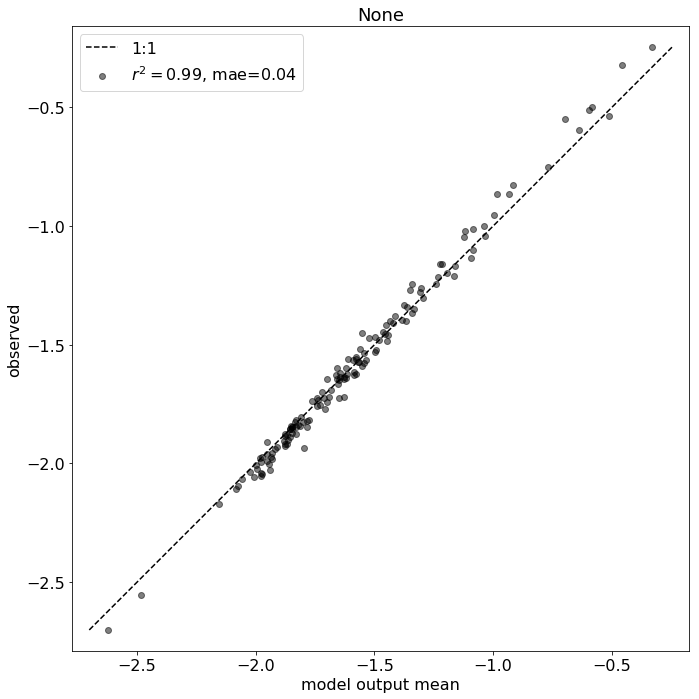

In [82]:
# Check fit on training model
ppc_train_l1_16HL = bnn_l1_16HL.predict(likelihood_name='likelihood')
bnn_l1_16HL.plot_model_fits(y_train, ppc_train_l1_16HL, loss_metric='mae', );

100%|██████████| 2000/2000 [00:01<00:00, 1111.66it/s]


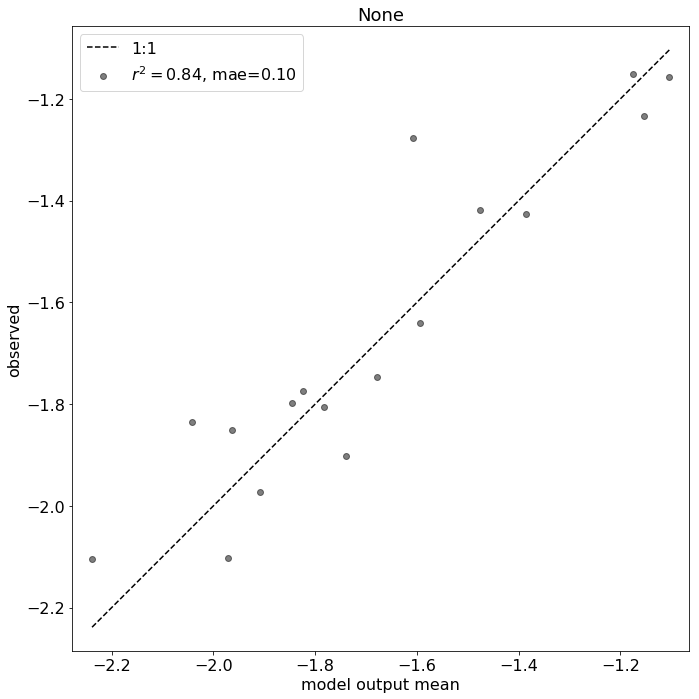

In [83]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l1_16HL = bnn_l1_16HL.predict(likelihood_name='likelihood')
bnn_l1_16HL.plot_model_fits(y_test, ppc_test_l1_16HL, loss_metric='mae',);

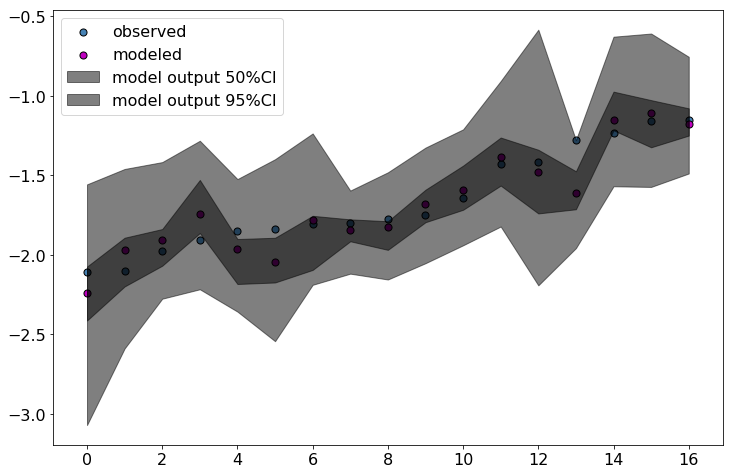

In [84]:
# Plot Fits with Uncertainty Estimates
iy  = np.argsort(y_test)
ix = np.arange(iy.size)
ppc_test = ppc_test_l1_16HL
lik_mean =ppc_test.mean(axis=0)
lik_hpd = pm.hpd(ppc_test)
lik_hpd_05 = pm.hpd(ppc_test, alpha=0.5)

f_fit2, ax = pl.subplots(figsize=(12, 8))
ax.scatter(ix, y_test.values[iy], label='observed', edgecolor='k', s=50,
           color='steelblue');
ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
               label='model output 50%CI');
ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
               label='model output 95%CI');
ax.legend(loc='upper left');

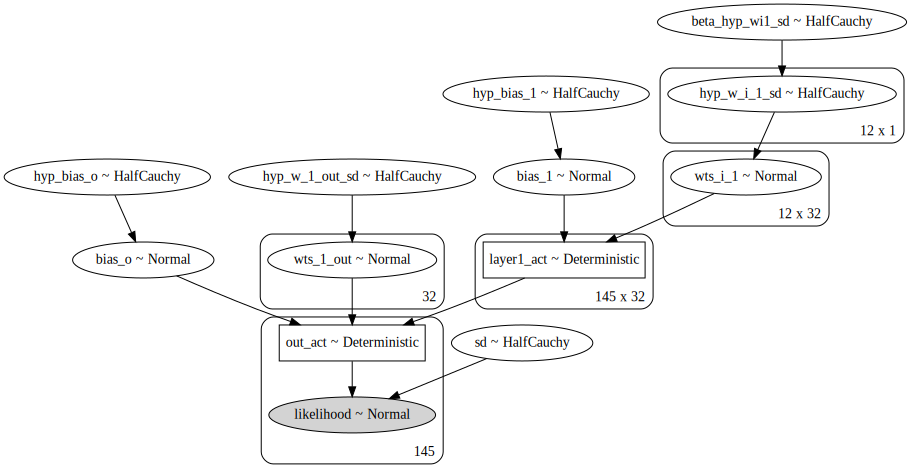

In [57]:
X_shared = shared(X_s_train.values)
bnn_l1_32HL = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train.log10_aphy411, n_hidden=32,)
bnn_l1_32HL.show_model()

In [58]:
bnn_l1_32HL.fit_ADVI(n_samples=10000, n_iter=20000, inference='svgd', inf_kwargs=dict(n_particles=200))

  0%|          | 75/20000 [00:02<10:17, 32.24it/s]


In [59]:
bnn_l1_32HL.fit_ADVI(n_samples=2000, n_iter=100000)

Average Loss = 71.786: 100%|██████████| 100000/100000 [01:14<00:00, 1337.75it/s]
Finished [100%]: Average Loss = 71.739


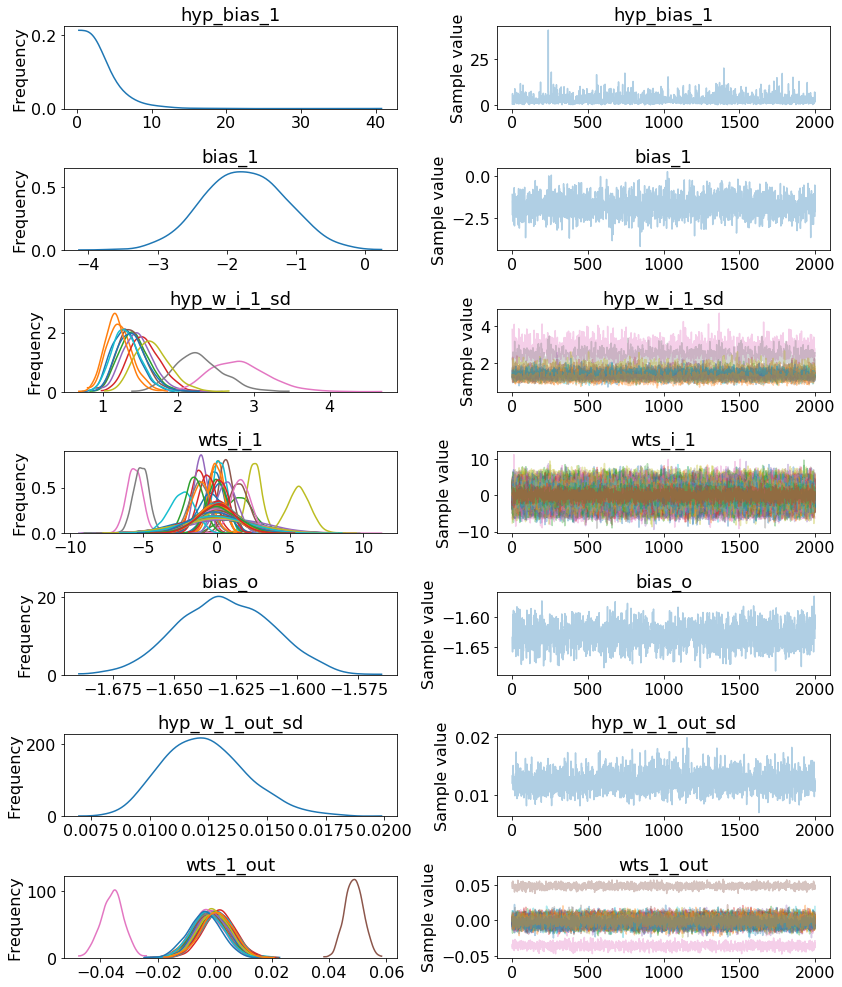

In [60]:
bnn_l1_32HL.evaluate_fit(['hyp_bias_1', 'bias_1', 'hyp_w_i_1_sd','wts_i_1', 'bias_o', 'hyp_w_1_out_sd', 'wts_1_out']);

100%|██████████| 2000/2000 [00:01<00:00, 1221.56it/s]


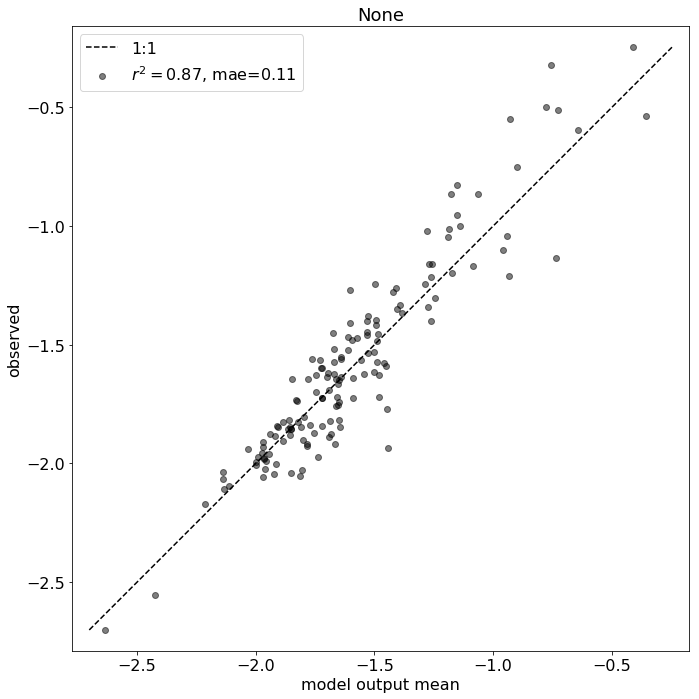

In [61]:
# Check fit on training model
ppc_train_l1_32HL = bnn_l1_32HL.predict(likelihood_name='likelihood')
bnn_l1_32HL.plot_model_fits(y_train.log10_aphy411, ppc_train_l1_32HL, loss_metric='mae', );

100%|██████████| 2000/2000 [00:01<00:00, 1045.36it/s]


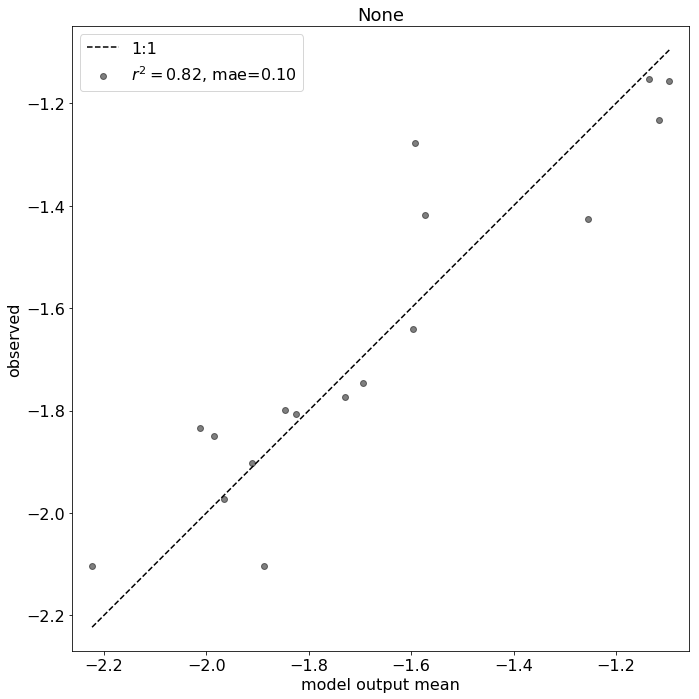

In [62]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l1_32HL = bnn_l1_32HL.predict(likelihood_name='likelihood')
bnn_l1_32HL.plot_model_fits(y_test.log10_aphy411, ppc_test_l1_32HL, loss_metric='mae',);

<u>Re-Train Model with Entire Data Set for Inter-Model Comparison</u>

In [96]:
bnn_l1.name = 'bnn_l1_4HL'
bnn_l1_8HL.name = 'bnn_l1_8HL'
bnn_l1_16HL.name = 'bnn_l1_16HL'
bnn_l1_32HL.name = 'bnn_l1_32HL'

In [97]:
pickledModelDict = {bnn_l1.model.name: bnn_l1,
                   bnn_l1_8HL.model.name: bnn_l1_8HL,
                   bnn_l1_16HL.model.name: bnn_l1_16HL,
                   bnn_l1_32HL.model.name: bnn_l1_32HL,
                   }
with open('./pickleJar/Models/Aphi%d_BNN_1HL_ARD_SVGD.pkl' % band, 'wb') as f:
    pickle.dump(pickledModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)